# Projet 4 de BioInformatique
Rémy Detobel - 000408013                
[rdetobel@ulb.ac.be](mailto:rdetobel@ulb.ac.be)        

------------------------

## Table des matières

- [Introduction](#Introduction)
- [Méthode](#Méthode)
    - [Parser](#Parser)
        - [Récupérer la liste des fichiers DSSP](#Récupérer-la-liste-des-fichiers-DSSP)
        - [Lecture du fichier](#Lecture-du-fichier)
        - [Charger une liste de séquences](#Charger-une-liste-de-séquences)
        - [Créer une prédiction](#Créer-une-prédiction)
        - [Sauvegarde](#Sauvegarde)
    - [Prédiction](#Prédiction)
    - [GOR 3](#GOR-3)
    - [ROC](#ROC)
- [Résultats](#Résultats)

## Introduction
Le but de ce projet est d'implémenter un algorithme `GOR III` qui permettra de prédire la structure d'une séquence d'acides aminés.

## Méthode
L'algorithme `GOR III` est donc un outil qui va permettre de calculer des prédictions.  Cette prédiction doit se baser sur des données.  Ces données ont été fournies par le professeur sous forme de fichier DSSP tiré de l'ensemble de `WHATIF`.        
Ces fichiers donnent diverses informations en plus de la chaine d'acides aminés comme par exemple la structure secondaire ou le résidu.  Son contenu exact sera détaillé un peu plus tard (lors de sa lecture).        
On retrouve 8 structures dans les fichiers DSSP.  On va les réduire à 4 classes de la manière suivante:

In [1]:
CONVERT_L_STRUCTURE = {'H':'H', 'G':'H', 'I':'H', # H,G,I -> H
                'E':'E', 'B':'E',                 # E,B -> E
                'T':'T',                          # T -> T
                'C':'C', 'S':'C', ' ':'C'}        # C,S,' ' -> C

En d'autres mots, les sturcutres G et I seront transformées en H; les structures B en E enfin, les structures S et espaces en C.           
On définit également quelques fonctions utiles concernant ces structures ainsi que la liste des 20 acides aminés.

In [2]:
def getStructure():
    return set(CONVERT_L_STRUCTURE.values())

def getAllStructure():
    return list(CONVERT_L_STRUCTURE.keys())

def convertStructure(lettreStructure):
    return CONVERT_L_STRUCTURE[lettreStructure]

def getAllAA():
    return ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

Pour lire les fichiers DSSP on se base sur un fichier `CATH_info` également fourni par le professeur.  Ce fichier se présente sous la forme suivante:
```
153LA Alpha
1A12A Beta
1A1IA Alpha/beta
```
On ne va s'intéresser qu'au premier mot de chaque ligne.  Les 4 premières lettres nous indiquent le nom du fichier.  Nous avons donc ici respectivement: `153L`, `1A12` et `1A1I`.  Le dernier caractère indique les lignes qui vont nous intéresser dans ce fichier.            
En effet, chaque fichier contient plus qu'une seule séquence.  Il faut donc sélectionner seulement les lignes dont la valeur en-dessous de RESIDU correspond à la dernière lettre présente dans le dit fichier.

### Parser
Pour lire ces données, nous allons utiliser une class `Parser` qui aura pour rôle de "parser" le fichier.  Ce code a été mis dans une class pour faciliter la structure de celui-ci.       
         
Le constructeur de Parser prend donc logiquement deux entrées.  Le fichier CATH_info qui va nous permettre de récupérer les fichiers DSSP et le dossier où se trouvent tous les DSSP.          

La class permet de créer une prédiction ou de simplement charger les fichiers présents dans le fichier CATH afin d'avoir une liste de séquences.  Mais pour faire cela il faut d'abord récupérer les fichiers DSSP contenus dans CATH ainsi que lire ces fichiers.           
       
##### Récupérer la liste des fichiers DSSP           
Pour ce faire, la class Parser contient une fonction génératrice.  Elle va simplement lire toutes les lignes du fichier CATH et renvoyer à chaque fois (via un `yield`) l'adresse vers le fichier DSSP ainsi que la lettre devant être utilisée pour sélectionner les bonnes lignes.            

##### Lecture du fichier        
Pour lire le fichier DSSP on va également procéder ligne par ligne.  Tout d'abord on vérifie que ce n'est pas un commentaire ou une information.  On passe donc toutes les lignes qui finissent par un point ou commencent par un `#`.   Les lignes suivantes contiennent donc toutes les données et se présentent comme ceci (les dernières colonnes ont été supprimées pour plus de clarté):
```
  #  RESIDUE AA STRUCTURE BP1 BP2  ACC     N-H-->O    O-->H-N    N-H-->O    O-->H-N    TCO  KAPPA ....
    1    3 A V              0   0  132      0, 0.0     2,-0.7     0, 0.0    46,-0.0   0.000 360.0 ....
    2    4 A I        +     0   0   64      1,-0.1    19,-0.2     5,-0.1     0, 0.0  -0.906 360.0 ....

```

On va donc couper la ligne là où il y a des espaces, ce qui va former plusieurs colonnes.  Seules les colonnes numéro 2, 4 et 5 (en commençant à 0) nous intéressent, elles correspondent respectivement au résidu (également nommé comme étant l'identifiant de la chaîne), l'acide aminé et la structure secondaire.        
           
Plus concrètement on a donc:
```
#  RESIDUE AA STRUCTURE BP1 BP2
   3  105 A Y  E     -A   14   0A
   Résidu ▲ |  |
Acide Aminé ▲  |
     Structure ▲
```

Cependant, certains fichiers contiennent quelques erreurs.  Par exemples des acides aminés n'existant pas ou un résidu collé au nombre qui le précède (comme ceci par exemple: `23AL`).  Pour ces deux raisons, le parsing est donc un peu plus fastidieux.  Lorsque l'on rencontre le premier problème, on ignore simplement la ligne.  Dans le second cas on prend le dernier caractère de ce regroupement et on décale les colonnes que l'on doit prendre (vu qu'il manque un espace tout est décalé d'une unité vers la gauche).
       
##### Charger une liste de séquences         
Le sous point précédent expliquait comment lire un fichier DSSP.  Pour récupérer une liste de séquences il suffit d'appliquer cette méthode sur tous les fichiers dont on veut récupérer les informations.
      
##### Créer une prédiction          
Pour créer une prédiction on va faire comme lorsque l'on charge une liste de séquence.  A la différence près que chaque fois que l'on récupère la séquence ainsi que la structure associée on l'injecte dans un objet `Prediction` qui sera détaillé ci-après.           
           
##### Sauvegarde             
L'objet Parser permet également de sauvegarder une liste de structures chargée.  Pour cela il suffit de préciser le nom du fichier où vont être sauvegardé les séquences et leurs structures.  La fonction `openSaveStrucAndSeq` permet de charger un fichier sauvegardé précédemment.        
Le parser ayant été utilisé pour créer une prédiction, peut également être sauvegardé mais dans un "format" propre à la class `Prediction` (et ce dans le simple but d'être plus efficace).

In [3]:
# Class permettant d'encapsuler le parser
class Parser:
    
    # On indique au parser le fichier cath qu'il va utiliser ainsi que le dossier 
    # où se touvent les fichiers DSSP
    def __init__(self, cathFile, dataFolder):
        self.cathFile = cathFile
        self.dataFolder = dataFolder

        self.seq = []
        self.struc = []


    # Générateur (via un yield) permettant d'avoir tous les fichiers DSSP
    def getDSSPFile(self, cathFile, dataFolder):
        # Ouverture du fichier
        fichier = open(cathFile, 'r')

        for ligne in fichier:
            ligne = ligne.strip()
            infos = ligne.split(' ')
            if(len(infos) >= 1):
                nomData = infos[0]

                extract = nomData[-1]
                nomData = nomData[:-1]

                yield (dataFolder + "/" + nomData), extract

    
    # Permet de traiter le contenu d'un fichier DSSP
    def loadDSSPFile(self, nomFichier, extractType):
        print("Traitement du fichier: " + str(nomFichier))

        resSeq = ""
        resStruc = ""

        fichier = open(nomFichier + ".dssp", 'r')
        for ligne in fichier:
            # Suppression des espaces
            ligne = ligne.strip()
            
            # Si la ligne est vide ou que c'est un commentaire
            if(len(ligne) > 0 and ligne[0] != '#' and ligne[len(ligne)-1] != '.'):
                ligneData = ligne.split()
                
                # Index de la colonne que l'on va lire
                index = 1
                
                # On regarde si la valeur dans la colonne 1 est un nombre.  Si ce n'est pas le cas c'est qu'il
                # manque un espace.  On décalle donc toutes les colonnes
                if(not ligneData[index].lstrip('-').isdigit()):
                    tmp = ligneData[index]
                    residu = tmp[len(tmp)-1]
                    index -= 1
                else:
                    residu = ligneData[index+1]
                
                residu = residu.upper()
                
                # Si le résidu ne fait pas partie du résidu que l'on doit lire dans ce fichier 
                if(not (residu in extractType)):
                    # on passe au suivant
                    continue

                aa = ligneData[index+2]
                aa = aa.upper()
                
                # Vérification que la variable est bien un acide aminé
                if(aa not in getAllAA()):
                    continue
                
                structure = ligneData[index+3]
                structure = structure.upper()
                
                
                # On vérifie que la structure existe et si ce n'est pas le cas
                # On la définit comme étant vide (la conversion se fait ensuite comme définie précédemment)
                if(not structure in getAllStructure()):
                    structure = ' '
                structure = convertStructure(structure)
                
                # On enregistre la structure et l'acide aminé
                resSeq += aa
                resStruc += structure
        fichier.close()

        return resSeq, resStruc
        
    
    # Permet de créer un objet Prediction (qui permettra par la suite de faire des prédictions)
    def createPrediction(self, saveFile = ""):
        prediction = Prediction()
        
        # On parcourt tous les fichiers
        for nameFile, extract in self.getDSSPFile(self.cathFile, self.dataFolder):
            resSeq, resStruc = self.loadDSSPFile(nameFile, extract)
            prediction.addSeqAndStruc(resSeq, resStruc)
            
        
        # On sauvegarde si cela a été précisé précédemment
        if(saveFile != ""):
            prediction.saveInFile(saveFile)

        return prediction

    
    # Permet de charger une structure et sa séquence
    def loadStrucAndSeq(self, saveFile = ""):
        fichier = None
        if(saveFile != ""):
            fichier = open(saveFile, 'w')
        
        for nameFile, extract in self.getDSSPFile(self.cathFile, self.dataFolder):
            resSeq, resStruc = self.loadDSSPFile(nameFile, extract)

            self.seq.append(resSeq)
            self.struc.append(resStruc)
            if(fichier != None):
                fichier.write("> " + nameFile + " | " + extract)
                fichier.write("\n")
                fichier.write(str(resSeq))
                fichier.write("\n")
                fichier.write(str(resStruc))
                fichier.write("\n")
                
        if(fichier != None):
            fichier.close()
            
        return self.seq, self.struc
    
    def openSaveStrucAndSeq(self, savedFile):
        fichier = open(savedFile, 'r')
        for ligne in fichier:
            ligne = ligne.strip()
            
            if(len(ligne) > 0 and ligne[0] != '>'):
                if(len(self.seq) == len(self.struc)):
                    self.seq.append(ligne)
                else:
                    self.struc.append(ligne)


    def getAllSequence(self):
        return self.seq

    def getAllStructure(self):
        return self.struc

### Prédiction
L'objet prédiction est une structure qui va nous faciliter le calcul des prédictions.  La class `Prediction` sera donc utilisée par l'objet `GOR3` qui se chargera de calculer à proprement parler la prédiction d'une séquence.

Dans la suite de ce rapport le terme "prédicteur" désignera l'objet `Prédiction` qui permet de calculer des prédictions (en effet, ce terme n'existe pas dans la langue française).
            
Comme dit dans l'introduction, notre prédiction va se baser sur une liste de séquences et de structures.  Il y a donc plusieurs manières de donner à notre prédicteur ces informations.  Tout d'abord via la méthode `addSeqAndStruc` qui permet de rajouter une séquence et une structure.  C'est cette fonction qui va être appelée lorsque l'on aura fini de lire un fichier DSSP et que l'on voudra directement créer une prédicition.            
Il est également possible de charger un fichier préalablement sauvegardé via la méthode `loadSaveFile`.  Le prédicteur contient trois dictionnaires, ces listes à clefs fonctionnent comme une base de données.  On calcule l'information une fois en entrée pour ne fournir que le résultat en sortie.  Lorsque l'on sauvegarde l'objet `Prediction`, il suffit de sauvegarder ces trois listes et inversement pour recharger une prédiction il suffit de recharger ces trois listes.            
Le premier dictionnaire stocke le nombre de fois que l'on retrouve une structure dans toutes les séquences, la seconde sauvegarde le nombre de fois que l'on a rencontré un couple `(structure, acide aminé)`.       
Enfin, le troisième dictionnaire permet de stocker un triplet de type: `(structure, acide aminé, acide aminé)`.  Le premier acide aminé est le même que celui utilisé dans le dictionnaire précédent.  Le second acide aminé provient d'un décalage de -8 à 8 par rapport à l'acide aminé que l'on est entrain de calculer.    Concrètement on peut donc modéliser ces listes par l'exemple suivant:            
```
                                      ▼
Structure:    H  E  T  T  T  T  T  H  E  C  H  T  E  H  H  E  E  T
Acide Amine:  C  P  W  W  Q  A  P  E  N  G  P  K  E  R  S  V  L  T
```
Nous avons traité tous les éléments avant le couple `(E, N)`.  Nous devons donc maintenant incrémenter les trois dictionnaires afin de remplir correctement notre "base de données".   Pour le premier dictionnaire c'est assez simple, il suffit d'incrémenter E.  Si l'on imagine que cette séquence est la première, notre premier dictionnaire ressemblera à ceci (en imaginant avoir traité la structure courante):
```
{H: 2, E: 2, T: 5}
```
Il nous faut ensuite traiter le second dictionnaire qui stocke les couples `(structure, acide aminé)`.  On a ici le couple `(E, N)`.  Il suffit là aussi de l'incrémenter.  Si l'on imagine à nouveau que cette séquence est la première, notre second dictionnaire ressemblera à ceci:
```
{H: {C: 1, E: 1}, E: {P: 1, N: 1}, T: {W: 2, Q: 1, A: 1, P: 1}}
```
Enfin, il nous faut calculer le troisième dictionnaire afin de stocker les triplets: `(structure, acide aminé, acide aminé)`.  Pour la position courante nous allons donc avoir 16 informations en plus...  C'est à dire:
```
(E, N, C); (E, N, P); (E, N, W); (E, N, W); (E, N, Q); (E, N, A); (E, N, P); (E, N, E); (E, N, G); (E, N, P); (E, N, K); (E, N, E); (E, N, R); (E, N, S); (E, N, V); (E, N, L)
```
Dans le cas présent, les données sont sauvegardées dans un dictionnaire afin de faciliter leur accès.  Cepenant, on peut très bien imaginer ce dernier dictionnaire comme une matrice à trois dimensions: 
![Matrice3D](./Images/matrix3D.png)
Cette image nous montre bien toutes les données qui sont sauvegardées.
         
L'objet `Prediction` ne fait rien de plus que de stocker, enregistrer et restituer les données présentes dans ces trois dictionnaires.

In [4]:
class Prediction:

    def __init__(self):
        self.freqStruc = {}
        self.freqStrucAA = {}
        self.freqStrucAAFen = {}


    def addSeqAndStruc(self, seq, struc):
        for indice in range(len(seq)):
            aa = seq[indice]
            structure = struc[indice]

            # Fréquence d'une structure
            self.calculFreqStruc(structure)

            # Fréquence d'une structure associée à un AA
            self.calculFreqStrucAA(structure, aa)

            # Fréquence d'une structure associée à un AA et avec un aa étant à un certain décalage
            if(not (structure in self.freqStrucAAFen)):
                self.freqStrucAAFen[structure] = {aa: {}}

            elif(not (aa in self.freqStrucAAFen[structure])):
                self.freqStrucAAFen[structure][aa] = {}

            for var in range(-8, 9):
                if(var != 0 and (indice+var) >= 0 and (indice+var) < len(seq)):
                    aaDec = seq[indice+var]
                    if(aaDec in self.freqStrucAAFen[structure][aa]):
                        self.freqStrucAAFen[structure][aa][aaDec] += 1
                    else:
                        self.freqStrucAAFen[structure][aa][aaDec] = 1


    def calculFreqStruc(self, structure):
        if(structure in self.freqStruc):
            self.freqStruc[structure] += 1
        else:
            self.freqStruc[structure] = 1


    def calculFreqStrucAA(self, structure, aa):
        if(structure in self.freqStrucAA):
            if(aa in self.freqStrucAA[structure]):
                self.freqStrucAA[structure][aa] += 1
            else:
                self.freqStrucAA[structure][aa] = 1
        else:
            self.freqStrucAA[structure] = {aa: 1}


    def saveInFile(self, fileName):
        fichier = open(fileName, 'w')
        fichier.write(str(self.freqStruc))
        fichier.write("\n")
        fichier.write(str(self.freqStrucAA))
        fichier.write("\n")
        fichier.write(str(self.freqStrucAAFen))
        fichier.close()
        print("Base de donnée enregistrée")


    def loadSaveFile(self, fileName):
        fichier = open(fileName, 'r')
        i = 0
        for ligne in fichier:
            ligne = ligne.strip()
            if(ligne != ""):
                if(i == 0):
                    self.freqStruc = eval(ligne)
                elif(i == 1):
                    self.freqStrucAA = eval(ligne)
                else:
                    self.freqStrucAAFen = eval(ligne)
                i += 1

        fichier.close()


    def getFreqStruc(self, structure):
        res = 0
        if(structure in self.freqStruc):
            res = self.freqStruc[structure]
        return res;

    def getFreqNotStruc(self, structure):
        res = 0
        for struc in getStructure():
            if(struc != structure):
                res += self.getFreqStruc(struc)
        return res


    def getFreqStrucAA(self, structure, AA):
        res = 0
        if(structure in self.freqStrucAA and AA in self.freqStrucAA[structure]):
            res = self.freqStrucAA[structure][AA]
        return res

    def getFreqNotStrucAA(self, structure, aa):
        res = 0
        for struc in getStructure():
            if(struc != structure):
                res += self.getFreqStrucAA(struc, aa)
        return res


    def getFreqStrucAAFene(self, structure, aaFenetre, aa):
        res = 0
        if(structure in self.freqStrucAAFen and aa in self.freqStrucAAFen[structure] and
                aaFenetre in self.freqStrucAAFen[structure][aa]):
            res = self.freqStrucAAFen[structure][aa][aaFenetre]
        return res

    def getFreqNotStrucAAFene(self, structure, aaFenetre, aa):
        res = 0
        for struc in getStructure():
            if(struc != structure):
                res += self.getFreqStrucAAFene(struc, aaFenetre, aa)
        return res

### GOR 3

C'est dans cette classe que se trouvent tous les calculs.  `GOR III` est un algorithme de prédiction; il est la troisième évolution de l'algorithme, mais pas la dernière.  Il existe également `GOR V` par exemple.       
Pour faire notre prédiction nous aurons donc besoin d'un objet `Prediction` qui sera utilisé comme base de données, ainsi que d'une séquence d'acide aminé que l'on désire prédire.         
Pour chaque acide aminé de la séquence, on va calculer une valeur pour chaque structure.  On va donc dans un premier temps calculer une matrice ayant une taille de `4 x TailleSequence` (4 étant le nombre de structures avec lesquelles on travaille).    
Pour calculer ces valeurs, nous allons utiliser une formule assez longue.  Pour l'expliquer et la calculer, elle a été divisée en deux.  La première partie consiste à prendre la valeur suivante:
```
valeurUn(S, AA) = log( f(S, AA) / f_n(S, AA) ) + log( f_n(S) / f(S) )
```
Où:
- **S**     
    Représente la strucutre dont on cherche la valeur
- **AA**        
    Représente l'acide aminé dont on cherche la valeur
- **f**      
    représente une fonction "fréquence" qui va être appelée sur la base de donnée afin de récupérer une valeur numérique
- **f_n**         
    fait la même chose que "f" mais en prennant toutes les valeurs sauf celle de la structure passée en paramètre.

Concrètement, `f(S, AA)` va donc simplement interroger la base de données concernant le nombre d'apparitions du couple `(S, AA)` dans toutes les séquences (la "base de données" va donc simplement renvoyer la valeur présente dans le second dictionnaire).   Pour `f_n(S, AA)`, la "base de données" va simplement additionner la valeur des 3 structures différentes de _S_.     
     
Pour calculer la seconde partie de l'équation, nous allons devoir à nouveau parcourir les 8 acides aminés avant et après celui que l'on est entrain de calculer.   Voici un cas concret:
```

                                      ▼
Acide Amine:  E  I  P  H  S  G  L  W  R  L  F  L  G  V  E  T  A  D  N
```
Pour cette seconde partie d'équation on va donc travailler avec trois valeurs.  L'acide aminé et la structure que l'on cherche (pour remplir notre matrice) mais également un acide aminé décalé (dans une fenêtre de -8, 8).   
La formule est donc:
```
valeurDeux(S, AA, AADec) = log( f(S, AADec, AA) / f_n(S, AADec, AA)) + log ( f_n(S, AA) / f(S, AA))
```
Où:
- **AADec**    
    N'est autre que la valeur décalée         
    
Pour mettre ces deux valeurs ensemble, il suffit de tout additionner comme ceci:
$$matrice(S, AA) = valeurUn(S, AA) + \sum_{AADec}(valeurDeux(S, AA, AADec))$$

Dans le cas précent ci-dessus, en imaginant que l'on soit sur l'acide aminé R.  Les différentes formules seraient:
```
matrice(H, R) = valeurUn(H, R) + (valeurDeux(H, R, E) + valeurDeux(H, R, I) + valeurDeux(H, R, P) + ... +
                valeurDeux(H, R, T) + valeurDeux(H, R, A))
matrice(C, R) = ...
matrice(E, R) = ...
matrice(T, R) = valeurUn(T, R) + (valeurDeux(T, R, E) + valeurDeux(T, R, I) + valeurDeux(T, R, P) + ... + 
                valeurDeux(T, R, T) + valeurDeux(T, R, A))

```

Une fois tout ceci calculé on va se retrouver avec une matrice comparable à celle-ci:

|   |   I   |   M   |   R   | ... |   Q   |
|:-:|:-----:|:-----:|:-----:|:---:|:-----:|
| H | 0.012 | 0.412 | 0.084 |     | 0.912 |
| E | 0.014 | 0.7   | 0.15  |     | 0.32  |
| T | 0.015 | 0.13  | 0.405 |     | 0.95  |
| C | 0.054 | 0.02  | 0.432 |     | 0.24  |

Note: les valeurs présentes dans ce tableau sont purement fictives.

     
Il ne nous reste plus qu'à donner notre prédiction.  Pour ce faire, il suffit de prendre la valeur la plus grande de chaque colonne.  Donc pour l'acide aminé I, la structure la plus probable est la C.  Pour l'acide aminé M (en seconde position), il s'agit de E.
        

In [5]:
from math import log
from math import sqrt


class GOR3:

    def __init__(self, prediction, testSeq):
        self.pred = prediction
        self.testSeq = testSeq
        self.result = ""

        self.calculGOR()
        self.getBestForPos()


    def calculGOR(self):
        self.matResult = []
        self.valueResult = {}

        for iAA in range(len(self.testSeq)):
            aa = self.testSeq[iAA]

            self.matResult.append([])

            for iStruc in range(len(getStructure())):
                structure = list(getStructure())[iStruc]

                # Premier terme
                num1 = self.pred.getFreqStrucAA(structure, aa)
                div1 = self.pred.getFreqNotStrucAA(structure, aa)

                num2 = self.pred.getFreqNotStruc(structure)
                div2 = self.pred.getFreqStruc(structure)

                total = log(num1 / div1) + log(num2 / div2)

                # Second terme
                for i in range(-8, 9):
                    if(i != 0 and (iAA+i) >= 0 and (iAA+i) < len(self.testSeq)):
                        aaDecal = self.testSeq[iAA+i]

                        num1 = self.pred.getFreqStrucAAFene(structure, aaDecal, aa)
                        div1 = self.pred.getFreqNotStrucAAFene(structure, aaDecal, aa)

                        num2 = self.pred.getFreqNotStrucAA(structure, aa)
                        div2 = self.pred.getFreqStrucAA(structure, aa)

                        total += log(num1 / div1) + log(num2 / div2)

                self.matResult[iAA].append(total)
                if(structure in self.valueResult):
                    self.valueResult[structure].append(total)
                else:
                    self.valueResult[structure] = [total]
        

    def getBestForPos(self):
        self.result = ""
        
        listeStruc = list(getStructure())

        for colonne in self.matResult:
            maxValue = max(colonne)
            
            structure = listeStruc[colonne.index(maxValue)]
            self.result += structure


    def getResult(self):
        return self.result


    def calculQ3(self, correctStruc):
        res = 0
        if(len(self.result) != len(correctStruc)):
            print("Erreur, il faut que le résultat ait la même taille que la structure correcte (" 
                + str(len(self.result)) + " et " + str(len(correctStruc)))
        else:
            correct = 0
            for index in range(len(self.result)):
                if(self.result[index] == correctStruc[index]):
                    correct += 1
            res = correct / len(self.result)

        return res


    def increment(self, dictionnaire, niveau1, niveau2):
        if(niveau1 in dictionnaire):
            if(niveau2 in dictionnaire[niveau1]):
                dictionnaire[niveau1][niveau2] += 1
            else:
                dictionnaire[niveau1][niveau2] = 1
        else:
            dictionnaire[niveau1] = {niveau2: 1}

        return dictionnaire


    def calculTFandPN(self, correctStruc):
        # TrueFalse PositiveNegative
        self.tfpn = {}
        for index in range(len(self.result)):
            corrStruc = correctStruc[index]
            prediStruc = self.result[index]

            value = "T" if corrStruc == prediStruc else "F"

            for struc in getStructure():

                if(struc == prediStruc):
                    res = value + "P"
                elif(struc == corrStruc or value == "T"):
                    res = value + "N"
                else:
                    continue

                self.tfpn = self.increment(self.tfpn, struc, res)

        for struc in self.tfpn:
            for elem in self.tfpn[struc]:
                if(elem == 0):
                    print("Erreur")
                    
            for val in ['TP', 'TN', 'FN', 'FP']:
                if(not(val in self.tfpn[struc])):
                    self.tfpn[struc][val] = 0 if(val in ['FN', 'FP']) else 1


    def calculMCC(self, correctStruc):
        self.calculTFandPN(correctStruc)

        res = {}
        if(len(self.result) != len(correctStruc)):
            print("Erreur, il faut que le résultat ai la même taille que la structure correcte (" 
                + str(len(self.result)) + " et " + str(len(correctStruc)))
        else:
            for struc in getStructure():
                
                    
                
                total = (self.tfpn[struc]['TP'] * self.tfpn[struc]['TN']) - \
                            (self.tfpn[struc]['FP'] * self.tfpn[struc]['FN'])
                total /= sqrt((self.tfpn[struc]['TP'] + self.tfpn[struc]['FP']) * 
                                (self.tfpn[struc]['TP'] + self.tfpn[struc]['FN']) * 
                                (self.tfpn[struc]['TN'] + self.tfpn[struc]['FP']) * 
                                (self.tfpn[struc]['TN'] + self.tfpn[struc]['FN']))

                res[struc] = total

        return res
    
                                    
    # Permet d'avoir le score qui nous a permis de déterminer que c'était la bonne structure
    def getMatricePrediction(self):
        return self.valueResult
    
    
    def getTPR(self, structure):
        return self.tfpn[structure]['TP'] / (self.tfpn[structure]['TP'] + self.tfpn[structure]['FN'])
    
    def getFPR(self, structure):
        return self.tfpn[structure]['TN'] / (self.tfpn[structure]['TN'] + self.tfpn[structure]['FP'])
    

Une fois que GOR3 a fait tous ses calculs, on peut récupérer les résultats en appellant la méthode `getResults`.  Il est également possible de voir la qualité de la prédiction à travers différents outils.     
Par exemple `Q3` permet de nous donner une approximation globale concernant la prédiction.  Il fait simplement le ratio entre les structures bien positionnées et le nombre total de structures.           

Pour préciser un peu la qualité d'une prédiction il est également possible de calculer son MCC (qui sont les initiales de `Matthews correlation coefficient`).  En se basant sur un principe de Vrai/Faux positifs/négatifs, il vise à préciser la qualité des prédictions pour chaque structure.        
Définition:
- **True Positif:**           
    Lorsque la prédiction correspond à la donnée et que la strucutre que l'on observe fait partie de cette correspondance.
- **True Négatif:**           
    Lorsque la prédiction est correcte (la même que la donnée) mais que la structure que l'on observe n'est pas la même que celle qui est correcte.
- **Faux Posifit:**           
    Lorsque la prédiction n'est pas correcte mais que la strucutre que l'on observe se trouve dans la prédiction.
- **Faux Négatif:**           
    Lorsque la prédiction n'est pas correcte mais que la structure que l'on observe se trouve dans les données.

Par exemple:
```
Réel:       H H H H H C C C C E E E E C C C E E E C C C H H H H
Prédiction: C H H H C C C C E E E E C C C E E E C C C H H H H C
```
On peut déjà calculer les True/False (qui ne changeront pas en fonction de la structure que l'on regarde:
```
True/False: F T T T F T T T F T T T F T T F T T F T T F T T T F
```
Pour la structure H, on peut donc calculer:
```
            N P P P N N N N / N N N / N N / N N / N N P P P P N
```
Au final, on a donc 6 TP, 12 TN, 1 FP et 3 FN.        
Pour calculer la valeur du MCC, on applique la formule suivante:
```
((TP * TN) - (FP * FN)) / (sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)))
```

### ROC
`ROC` sont les initiales de `Receiver Operating Characteristic`, il s'agit d'une représentation graphique permettant de visualiser la qualité des prédictions faites.       
La class `ROC` va permettre de calculer et tracer le grahique.  Pour se faire, le code va se baser sur les valeurs qui ont été calculées dans l'objet `GOR3` (la matrice résultante) pour adapter les valeurs de `True Positif` et `False Positif`.  Chaque point représentera le ratio entre le False/True Positif (pour respectivement l'axe X/Y) et le nombre total de Negatif/Positif (respectivement pour X/Y).         
L'algorithme en lui-même suit ce qui a été montré dans le cours (slide 30 du L10 "prediction structure secondaire").

In [6]:
import matplotlib.pyplot as plt

class ROC:
    
    def __init__(self, bonneSeq, seq, matricePrediction):
        if(len(seq) != len(bonneSeq)):
            print("Erreur, les séquences doivent avoir la même longueur (" + \
                  str(len(seq)) + " != " + str(len(bonneSeq)))
        
        self.seq = seq
        self.bonneSeq = bonneSeq
        self.matricePrediction = matricePrediction
        self.calculPositifNegatif()
    
    def calculPositifNegatif(self):
        self.P = 0
        self.N = 0
        for j in range(len(self.seq)):
            if self.seq[j] == self.bonneSeq[j]:
                self.P += 1
            else:
                self.N += 1
    
    def initListD(self, structure):
        self.LD = []
        for i in range(len(self.matricePrediction[structure])):
            self.LD.append((self.matricePrediction[structure][i], i))
        
        self.LD = sorted(self.LD, key=lambda x: x[0])
    
    
    def getCoord(self, structure):
        self.initListD(structure)
        
        FP = 0
        TP = 0
        
        resX = []
        resY = []
        
        valuePrecedent = None
        i = 0
        
        while i < len(self.seq):
            valuePrediction = self.matricePrediction[structure][i]
            if valuePrediction != valuePrecedent:
                resX.append(FP/self.N)
                resY.append(TP/self.P)
                valuePrecedent = valuePrediction
            
            nextPos = self.LD[i][1]
            if(self.seq[nextPos] == self.bonneSeq[nextPos]):
                TP += 1
            else:
                FP += 1
            
            i+=1
            
        resX.append(FP/self.N)
        resY.append(TP/self.P)
        
        return resX, resY
    
    
    def draw(self, structure):
        listX, listY = self.getCoord(structure)
        
        listX.sort()
        listY.sort()

        plt.plot(listX, listY)

        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])

        plt.title("Courbe ROC " + structure)
        plt.grid(True)
        plt.show()

## Résultats

Toutes les strucutres et calculs ont été implémentés.  On peut donc maintenant faire un test avec une séquence concrète que l'on va prédire.  Mais avant cela il faut créer notre prédicteur et charger les séquences de tests.

In [7]:
# On va récupérer les informations
parser = Parser("./DATA/CATH_info.txt", "./DATA/dssp")
# On crée le prédicteur
prediction = parser.createPrediction()

# On récupère les fichiers de tests
parserTest = Parser("./DATA/CATH_info_test.txt", "./DATA/dssp_test")
allSeq, allStruc = parserTest.loadStrucAndSeq("test.txt")

Traitement du fichier: ./DATA/dssp/153L
Traitement du fichier: ./DATA/dssp/1A12
Traitement du fichier: ./DATA/dssp/1A1I
Traitement du fichier: ./DATA/dssp/1A2P
Traitement du fichier: ./DATA/dssp/1A2Z
Traitement du fichier: ./DATA/dssp/1A34
Traitement du fichier: ./DATA/dssp/1A3A
Traitement du fichier: ./DATA/dssp/1A4I
Traitement du fichier: ./DATA/dssp/1A58
Traitement du fichier: ./DATA/dssp/1A6M
Traitement du fichier: ./DATA/dssp/1A73
Traitement du fichier: ./DATA/dssp/1A7S
Traitement du fichier: ./DATA/dssp/1A88
Traitement du fichier: ./DATA/dssp/1A8E
Traitement du fichier: ./DATA/dssp/1A8L
Traitement du fichier: ./DATA/dssp/1A8Q
Traitement du fichier: ./DATA/dssp/1A8S
Traitement du fichier: ./DATA/dssp/1A8U
Traitement du fichier: ./DATA/dssp/1AAP
Traitement du fichier: ./DATA/dssp/1ABA
Traitement du fichier: ./DATA/dssp/1AFW
Traitement du fichier: ./DATA/dssp/1AG9
Traitement du fichier: ./DATA/dssp/1AGI
Traitement du fichier: ./DATA/dssp/1AGJ
Traitement du fichier: ./DATA/dssp/1AGQ


On peut maintenant prédire la première séquence:

In [8]:
testSeqUn = allSeq[0]
testStrucUn = allStruc[0]

gor3_1 = GOR3(prediction, testSeqUn)
print("Prédiction: " + str(gor3_1.getResult()))
print("Données:    " + "".join(testStrucUn))

Prédiction: ETTETEETEEEEETETTHHHHHHHHHHHHHHHHHHHHETEEEHTETEEEEEETETTTTETEEEETETEHTETEEEHHHTHHEEHTEETTETTTTTECEEHTHHTEEETEECTTTTEEECTTHTTHEETEHTEETTTEEETETETTTETHTETTETETTTTETTEEETHEETEEEEETTEETEETTETTETEEEHHHHHTTEEEETETEEEETETTHEHHTHHHHHHHHHHHHEETETEEETEEEEEEEEEECTEETEEETETETEEEEETETTCTTHTEEETHHHHHCCHHHHHHTEHEEETEEETT
Données:    CCCTTTCCTTCCCCHHHHHHHHHHHHHHCTTTEEEEEEEECTTCCEEEEEEECCCCCCCCEEEEEECCCTTCHHHHHHHHHHHHHHHHHTTTCHHHHHHHHHCEEEEECCCCHHHHHHHHHTCTTCCCCCCCCCCCCCCCCCHHHCCCCCTTCCCCECCTTCTTECCCCTTCCHHHHHHHHHHHHHCCEEEEEEEEECCCEEEECCCCCCCCCTTHHHHHHHHHHHHHHHHHHHCCCCEEEEHHHHCCCCCCCHHHHHHHTTCCEEEEEEECCCCCCHHHCCHHHHHHHHHHHHHHHHHHHHHHHHC


Comme expliqué précédemment, il n'est pas simple de comparer ces deux chaines.  Nous allons donc utiliser les outils définis précédemment.

In [9]:
print("Pourcent: Q3: " + str(gor3_1.calculQ3(testStrucUn)*100) + "%")

print("")
for struc, total in gor3_1.calculMCC(testStrucUn).items():
    print("MCC " + str(struc) + ": " + str(total))

Pourcent: Q3: 30.944625407166125%

MCC E: 0.031230707451940523
MCC T: -0.07792223009268319
MCC H: 0.05813327651607324
MCC C: -0.034014792182586295


Le `Q3` nous indique que la prédiction n'est pas très bonne.  Les MCC sont en accord avec le Q3, voire même encore plus pessimistes quant à l'exactitude de cette prédiction.  En effet, le MCC retourne une valeur entre -1 et 1.  Au plus le nombre est grand, au plus la prédiction est correcte.  Dans le cas présent, les strucutres C et T ont des mauvaises prédictions tandis que H et E sont proches d'une prédiction aléatoire.

          
          
Nous allons maintenant faire les prédictions de toutes les séquences présentes dans le fichier de Test:

In [10]:
allStrSeq = ""
allStrStruc = ""
totalMatrice = None

for iSeq in range(len(allSeq)):
    seq = allSeq[iSeq]
    struc = allStruc[iSeq]
    
    print("-=- Séquence " + str(iSeq+1) + " -=-")
    gor3 = GOR3(prediction, seq)
    print("Prédiction: " + gor3.getResult())
    print("Donnée:     " + struc)
    print("")
    print("Q3: " + str(gor3.calculQ3(struc)*100) + "%")
    for gorStruc, gorTotal in gor3.calculMCC(struc).items():
        print("MCC " + str(gorStruc) + ": " + str(gorTotal))
    print("")
    print("")
    allStrSeq += gor3.getResult()
    allStrStruc += struc
    
    matPrediction = gor3.getMatricePrediction()
    
    if(totalMatrice == None):
        totalMatrice = matPrediction
    else:
        for lettre in totalMatrice.keys():
            totalMatrice[lettre] += matPrediction[lettre]
    

-=- Séquence 1 -=-
Prédiction: ETTETEETEEEEETETTHHHHHHHHHHHHHHHHHHHHETEEEHTETEEEEEETETTTTETEEEETETEHTETEEEHHHTHHEEHTEETTETTTTTECEEHTHHTEEETEECTTTTEEECTTHTTHEETEHTEETTTEEETETETTTETHTETTETETTTTETTEEETHEETEEEEETTEETEETTETTETEEEHHHHHTTEEEETETEEEETETTHEHHTHHHHHHHHHHHHEETETEEETEEEEEEEEEECTEETEEETETETEEEEETETTCTTHTEEETHHHHHCCHHHHHHTEHEEETEEETT
Donnée:     CCCTTTCCTTCCCCHHHHHHHHHHHHHHCTTTEEEEEEEECTTCCEEEEEEECCCCCCCCEEEEEECCCTTCHHHHHHHHHHHHHHHHHTTTCHHHHHHHHHCEEEEECCCCHHHHHHHHHTCTTCCCCCCCCCCCCCCCCCHHHCCCCCTTCCCCECCTTCTTECCCCTTCCHHHHHHHHHHHHHCCEEEEEEEEECCCEEEECCCCCCCCCTTHHHHHHHHHHHHHHHHHHHCCCCEEEEHHHHCCCCCCCHHHHHHHTTCCEEEEEEECCCCCCHHHCCHHHHHHHHHHHHHHHHHHHHHHHHC

Q3: 30.944625407166125%
MCC E: 0.031230707451940523
MCC T: -0.07792223009268319
MCC H: 0.05813327651607324
MCC C: -0.034014792182586295


-=- Séquence 2 -=-
Prédiction: CCCCCECCCCTCTEHHTHTHHHHTHTEHTTTTEEETTTETTTTTEEECTTTTTEECTETEEECCETEECTTTEEEETETEEEHHTHEHHHHHHHHHHHHHHHHHTETEEECTCECCCCCCTTHTEEHHHHHHTHHEHTEHHHTTTETTETEETTETTTHEEETEETTETEE

**Séquence 1**:          
Elle a déjà été comparée ci-dessus.          
**Séquence 2**:            
Son Q3 est légèrement meilleur que la première prédiction.  Cependant, les MCC nous montrent que seule la structure C à une bonne prédiction.      
**Séquence 3**:           
La séquence 3 est la meilleure prédiction de toutes les séquences de tests.  Son Q3 est légèrement suppérieur à 50%, cela signifie que plus d'une structure sur deux est bien placée.  On remarque également que tous les MCC sont positifs et supérieurs à un dixième.     
**Séquence 4**:         
La quatrième séquence est comparable à la première prédiction.  En effet, malgré le fait que Q3 soit meilleur, les MCC nous montrent que seules les structures T et H sont correctement prédites.        
**Séquence 5**:            
Comme la troisième séquence, la prédiction 5 à tous ses MCC positifs.  Ce qui est assez logique vu qu'elle a également un Q3 assez _élevé_ comparé aux autres prédictions.

         

Nous pouvons maintenant voir la qualité de notre prédicteur en utilisant une courbe ROC (dont l'algorithme a été détaillé plus haut).

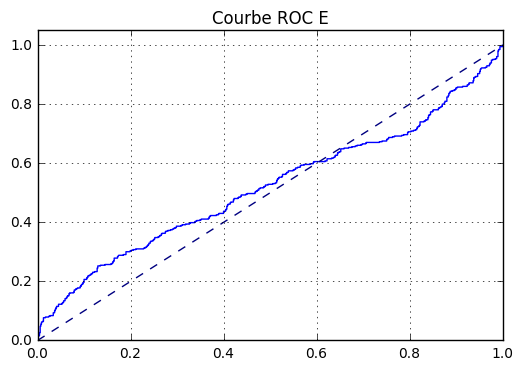

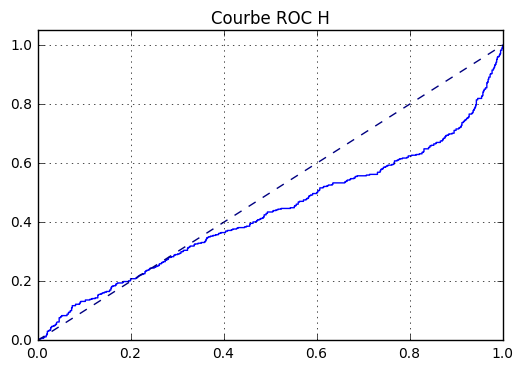

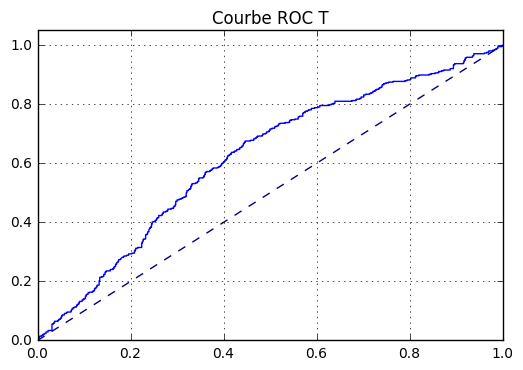

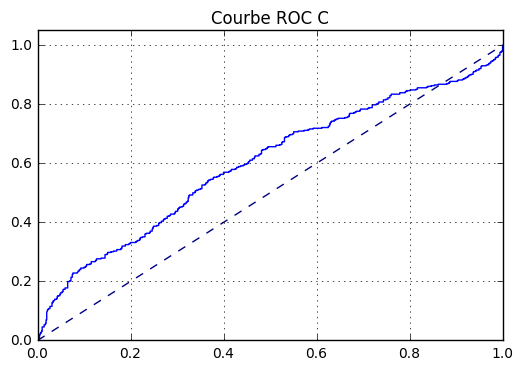

In [11]:
roc = ROC(allStrStruc, allStrSeq, totalMatrice)
roc.draw("E")
roc.draw("H")
roc.draw("T")
roc.draw("C")

On remarque que de manière générale notre prédicteur n'a pas une très bonne courbe de ROC et donc par conséquence de mauvaises prédictions.           
La diagonale allant de 0, 0 à 1, 1 est la droite indiquant la probabilité aléatoire.  Si la courbe se trouve au-dessus de cette ligne cela signifie que la prédiction est bonne.  Si elle est en-dessous cela signifie que la prédiction est moins bonne que l'aléatoire.         
On notera également qu'au plus la courbe est proche de (0, 1) au mieux c'est.        
Avec ces deux informations, on voit très bien que H à une très mauvaise courbe de ROC et qu'aucune courbe ne se rapproche réellement du point (0, 1).         
Cela confirme bien les autres estimateurs concernant les mauvais résultats de notre prédicteur.